# *Advanced example* from the docs: Gaussian quarter ring

In [1]:
# Configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
try:
    from cobaya.run import run
except ImportError:
    sys.path.insert(0,'../../cobaya')
    from cobaya.run import run

### Defining the *Gaussian ring* likelihood and priors for its parameters

In [2]:
import numpy as np
from scipy import stats

def gauss_ring_logp(x, y):
    return stats.norm.logpdf(np.sqrt(x**2+y**2), loc=1, scale=0.02)

info = {"likelihood": {"ring": gauss_ring_logp}}

In [3]:

info["params"] = {
    "x": {"prior": {"min": 0, "max": 2}, "ref": 0.5, "proposal": 0.01},
    "y": {"prior": {"min": 0, "max": 2}, "ref": 0.5, "proposal": 0.01}}

### Defining *dynamical* derived parameters: radius and angle

In [4]:
get_r = lambda x,y: np.sqrt(x**2+y**2)
get_theta = lambda x,y: np.arctan(y/x)

info["params"]["r"] = {"derived": get_r}
info["params"]["theta"] = {"derived": get_theta,
                           "latex": r"\theta", "min": 0, "max": np.pi/2}

# N.B.: the options "min" and "max" for theta are not a prior (it is not a sampled parameter!)
# but the ranges used by GetDist to plot and derive marginal distributions for theta.

### Sample and plot!

In [5]:
# Very non-gaussian shape: increase the default convergence criterion and
# increase limit on tries before chain gets stuck
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}

from cobaya.run import run
updated_info, sampler = run(info)

[ring] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {ring: 8580.0}
[mcmc] *WARNING* `i_last_slow_block` is only well defined when dragging.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: x:0.5, y:0.5
[mcmc] Sampling! (NB: no accepted step will be saved until 40 burn-in samples have been obtained)
[mcmc] Progress @ 2020-04-07 19:46:02 : 1 steps taken -- still burning in, 41 accepted steps left.
[mcmc] Finished burn-in phase: discarded 40 accepted steps.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.684
[mcmc]  - Convergence of means: R-1 = 2.125947 after 80 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcm

[mcmc]  - Acceptance rate: 0.114
[mcmc]  - Convergence of means: R-1 = 0.007701 after 2720 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2800 samples accepted.
[mcmc]  - Acceptance rate: 0.114
[mcmc]  - Convergence of means: R-1 = 0.008827 after 2800 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2880 samples accepted.
[mcmc]  - Acceptance rate: 0.114
[mcmc]  - Convergence of means: R-1 = 0.007649 after 2880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2960 samples accepted.
[mcmc]  - Acceptance rate: 0.114
[mcmc]  - Convergence of means: R-1 = 0.004014 after 2960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3040 samples accepted.
[mcmc]  - Acceptance rate: 0.113
[mcmc]  - Convergence of means: R-1 = 0.010468 after 3040 accepted steps
[mcmc]  - Updated covariance m

[mcmc]  - Acceptance rate: 0.102
[mcmc]  - Convergence of means: R-1 = 0.006500 after 5760 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5840 samples accepted.
[mcmc]  - Acceptance rate: 0.102
[mcmc]  - Convergence of means: R-1 = 0.007024 after 5840 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5920 samples accepted.
[mcmc]  - Acceptance rate: 0.102
[mcmc]  - Convergence of means: R-1 = 0.005198 after 5920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6000 samples accepted.
[mcmc]  - Acceptance rate: 0.102
[mcmc]  - Convergence of means: R-1 = 0.006541 after 6000 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6080 samples accepted.
[mcmc]  - Acceptance rate: 0.101
[mcmc]  - Convergence of means: R-1 = 0.007517 after 6080 accepted steps
[mcmc]  - Updated covariance m

[mcmc]  - Acceptance rate: 0.097
[mcmc]  - Convergence of means: R-1 = 0.003912 after 8800 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8880 samples accepted.
[mcmc]  - Acceptance rate: 0.097
[mcmc]  - Convergence of means: R-1 = 0.008381 after 8880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8960 samples accepted.
[mcmc]  - Acceptance rate: 0.097
[mcmc]  - Convergence of means: R-1 = 0.007075 after 8960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9040 samples accepted.
[mcmc]  - Acceptance rate: 0.096
[mcmc]  - Convergence of means: R-1 = 0.006921 after 9040 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9120 samples accepted.
[mcmc]  - Acceptance rate: 0.096
[mcmc]  - Convergence of means: R-1 = 0.005785 after 9120 accepted steps
[mcmc]  - Updated covariance m

[mcmc] Learn + convergence test @ 11840 samples accepted.
[mcmc]  - Acceptance rate: 0.095
[mcmc]  - Convergence of means: R-1 = 0.004695 after 11840 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 11920 samples accepted.
[mcmc]  - Acceptance rate: 0.095
[mcmc]  - Convergence of means: R-1 = 0.003170 after 11920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12000 samples accepted.
[mcmc]  - Acceptance rate: 0.095
[mcmc]  - Convergence of means: R-1 = 0.002126 after 12000 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12080 samples accepted.
[mcmc]  - Acceptance rate: 0.095
[mcmc]  - Convergence of means: R-1 = 0.001297 after 12080 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12160 samples accepted.
[mcmc]  - Acceptance rate: 0.095
[mcmc]  - Convergence of means: R-1 =

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 14880 samples accepted.
[mcmc]  - Acceptance rate: 0.094
[mcmc]  - Convergence of means: R-1 = 0.003753 after 14880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 14960 samples accepted.
[mcmc]  - Acceptance rate: 0.094
[mcmc]  - Convergence of means: R-1 = 0.003609 after 14960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 15040 samples accepted.
[mcmc]  - Acceptance rate: 0.094
[mcmc]  - Convergence of means: R-1 = 0.003182 after 15040 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 15120 samples accepted.
[mcmc]  - Acceptance rate: 0.094
[mcmc]  - Convergence of means: R-1 = 0.002962 after 15120 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 15200 samples accepted.
[mcmc]  - Accepta

[mcmc]  - Convergence of means: R-1 = 0.001637 after 17840 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 17920 samples accepted.
[mcmc]  - Acceptance rate: 0.094
[mcmc]  - Convergence of means: R-1 = 0.000922 after 17920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 18000 samples accepted.
[mcmc]  - Acceptance rate: 0.094
[mcmc]  - Convergence of means: R-1 = 0.001029 after 18000 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 18080 samples accepted.
[mcmc]  - Acceptance rate: 0.094
[mcmc]  - Convergence of means: R-1 = 0.000873 after 18080 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 18160 samples accepted.
[mcmc]  - Acceptance rate: 0.094
[mcmc]  - Convergence of means: R-1 = 0.001258 after 18160 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[

[mcmc] Learn + convergence test @ 20880 samples accepted.
[mcmc]  - Acceptance rate: 0.093
[mcmc]  - Convergence of means: R-1 = 0.002086 after 20880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 20960 samples accepted.
[mcmc]  - Acceptance rate: 0.093
[mcmc]  - Convergence of means: R-1 = 0.001768 after 20960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 21040 samples accepted.
[mcmc]  - Acceptance rate: 0.093
[mcmc]  - Convergence of means: R-1 = 0.001570 after 21040 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 21120 samples accepted.
[mcmc]  - Acceptance rate: 0.093
[mcmc]  - Convergence of means: R-1 = 0.001498 after 21120 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 21200 samples accepted.
[mcmc]  - Acceptance rate: 0.093
[mcmc]  - Convergence of means: R-1 =

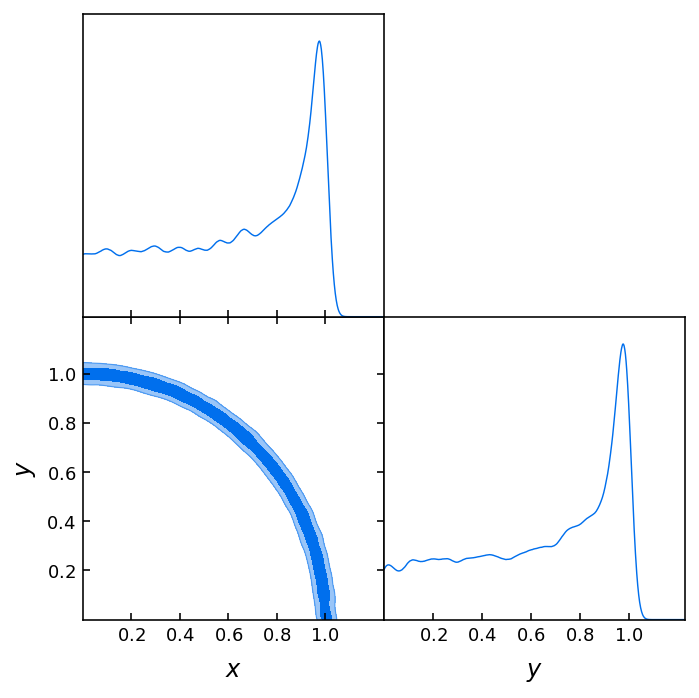

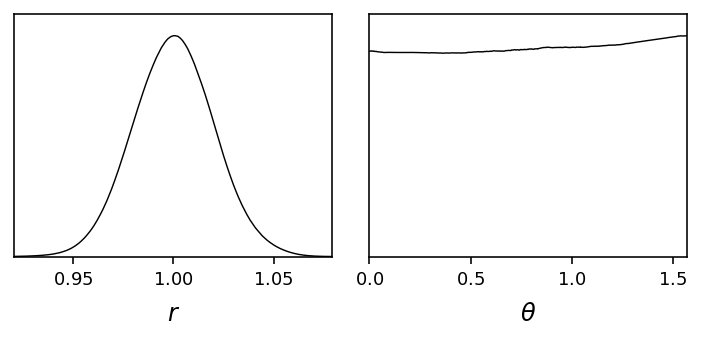

In [6]:
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

products = sampler.products()
gdsamples = MCSamplesFromCobaya(updated_info, products["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["x", "y"], filled=True)
gdplot.export("example_adv_ring.png")
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.plots_1d(gdsamples, ["r", "theta"], nx=2)
gdplot.export("example_adv_r_theta.png")

### Imposing a Gaussian band along $x=y$

In [7]:
info["prior"] = {"x_eq_y_band": lambda x, y: stats.norm.logpdf(x - y, loc=0, scale=0.3)}

from cobaya.run import run
updated_info_x_eq_y, sampler_x_eq_y = run(info)

[prior] *WARNING* External prior 'x_eq_y_band' loaded. Mind that it might not be normalized!
[tools] *WARNING* *DEPRECATION*: The env var 'COBAYA_MODULES' will be deprecated in favor of 'COBAYA_PACKAGES_PATH' in the next version. Please, use that one instead.
[ring] Initialized external likelihood.
[tools] *WARNING* *DEPRECATION*: The env var 'COBAYA_MODULES' will be deprecated in favor of 'COBAYA_PACKAGES_PATH' in the next version. Please, use that one instead.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {ring: 12900.0}
[mcmc] *WARNING* `i_last_slow_block` is only well defined when dragging.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: x:0.5, y:0.5
[mcmc] Sampling! (NB: no accepted step will be saved until 40 burn-in samples have been obtained)
[mc

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2720 samples accepted.
[mcmc]  - Acceptance rate: 0.245
[mcmc]  - Convergence of means: R-1 = 0.013955 after 2720 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2800 samples accepted.
[mcmc]  - Acceptance rate: 0.245
[mcmc]  - Convergence of means: R-1 = 0.009368 after 2800 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2880 samples accepted.
[mcmc]  - Acceptance rate: 0.244
[mcmc]  - Convergence of means: R-1 = 0.006947 after 2880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2960 samples accepted.
[mcmc]  - Acceptance rate: 0.243
[mcmc]  - Convergence of means: R-1 = 0.024753 after 2960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3040 samples accepted.
[mcmc]  - Acceptance rate:

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5760 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.006021 after 5760 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5840 samples accepted.
[mcmc]  - Acceptance rate: 0.210
[mcmc]  - Convergence of means: R-1 = 0.011946 after 5840 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5920 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.011096 after 5920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6000 samples accepted.
[mcmc]  - Acceptance rate: 0.208
[mcmc]  - Convergence of means: R-1 = 0.008159 after 6000 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6080 samples accepted.
[mcmc]  - Acceptance rate:

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8800 samples accepted.
[mcmc]  - Acceptance rate: 0.194
[mcmc]  - Convergence of means: R-1 = 0.003119 after 8800 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8880 samples accepted.
[mcmc]  - Acceptance rate: 0.194
[mcmc]  - Convergence of means: R-1 = 0.002535 after 8880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8960 samples accepted.
[mcmc]  - Acceptance rate: 0.194
[mcmc]  - Convergence of means: R-1 = 0.002509 after 8960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9040 samples accepted.
[mcmc]  - Acceptance rate: 0.194
[mcmc]  - Convergence of means: R-1 = 0.002221 after 9040 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9120 samples accepted.
[mcmc]  - Acceptance rate:

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 11840 samples accepted.
[mcmc]  - Acceptance rate: 0.189
[mcmc]  - Convergence of means: R-1 = 0.003498 after 11840 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 11920 samples accepted.
[mcmc]  - Acceptance rate: 0.189
[mcmc]  - Convergence of means: R-1 = 0.003464 after 11920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12000 samples accepted.
[mcmc]  - Acceptance rate: 0.188
[mcmc]  - Convergence of means: R-1 = 0.003557 after 12000 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12080 samples accepted.
[mcmc]  - Acceptance rate: 0.188
[mcmc]  - Convergence of means: R-1 = 0.003821 after 12080 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12160 samples accepted.
[mcmc]  - Accepta

[mcmc]  - Convergence of means: R-1 = 0.000723 after 14800 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 14880 samples accepted.
[mcmc]  - Acceptance rate: 0.185
[mcmc]  - Convergence of means: R-1 = 0.000824 after 14880 accepted steps
[mcmc]  - Convergence of bounds: R-1 = 0.030504 after 14880 accepted steps
[mcmc] The run has converged!
[mcmc] Sampling complete after 14880 accepted steps.


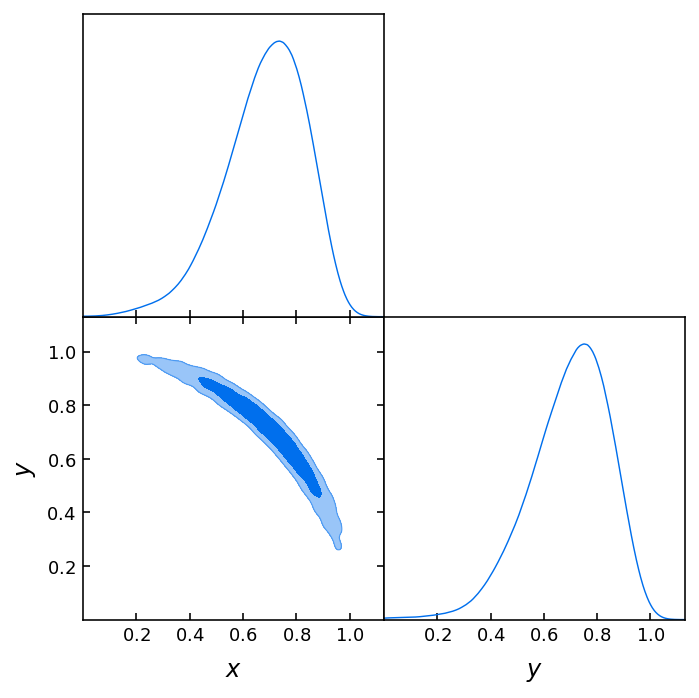

In [8]:
products_x_eq_y = sampler_x_eq_y.products()
gdsamples_x_eq_y = MCSamplesFromCobaya(
    updated_info_x_eq_y, products_x_eq_y["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_x_eq_y, ["x", "y"], filled=True)
gdplot.export("example_adv_band.png")

## Alternative: $r$ and $\theta$ as derived parameters of the likelihood

In [9]:
# List available derived parameters in the 'output_params' option of the likelihood.
# To make room for that, you need assign the function to the option 'external'.
# Return both the log-likelihood and a dictionary of derived parameters.
def gauss_ring_logp_with_derived(x, y):
    r = np.sqrt(x**2+y**2)
    derived = {"r": r, "theta": np.arctan(y/x)}
    return stats.norm.logpdf(r, loc=1, scale=0.02), derived

info_alt = {"likelihood": {"ring":
    {"external": gauss_ring_logp_with_derived, "output_params": ["r", "theta"]}}}

# Now we don't need to *define* (but do need to *mention*) r or theta
# if we want their values included in the chain
info_alt["params"] = {
    "x": {"prior": {"min": 0, "max": 2}, "ref": 0.5, "proposal": 0.01},
    "y": {"prior": {"min": 0, "max": 2}, "ref": 0.5, "proposal": 0.01},
    "r": None,
    "theta": {"latex": r"\theta", "min": 0, "max": np.pi/2}}
# Copy the prior and sampler info from the old one
info_alt["prior"] = info["prior"]
info_alt["sampler"] = info["sampler"]

# And run
updated_info_alt, sampler_alt = run(info_alt)

[prior] *WARNING* External prior 'x_eq_y_band' loaded. Mind that it might not be normalized!
[tools] *WARNING* *DEPRECATION*: The env var 'COBAYA_MODULES' will be deprecated in favor of 'COBAYA_PACKAGES_PATH' in the next version. Please, use that one instead.
[ring] Initialized external likelihood.
[tools] *WARNING* *DEPRECATION*: The env var 'COBAYA_MODULES' will be deprecated in favor of 'COBAYA_PACKAGES_PATH' in the next version. Please, use that one instead.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {ring: 11300.0}
[mcmc] *WARNING* `i_last_slow_block` is only well defined when dragging.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: x:0.5, y:0.5
[mcmc] Sampling! (NB: no accepted step will be saved until 40 burn-in samples have been obtained)
[mc

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2720 samples accepted.
[mcmc]  - Acceptance rate: 0.250
[mcmc]  - Convergence of means: R-1 = 0.040964 after 2720 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2800 samples accepted.
[mcmc]  - Acceptance rate: 0.246
[mcmc]  - Convergence of means: R-1 = 0.038428 after 2800 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2880 samples accepted.
[mcmc]  - Acceptance rate: 0.244
[mcmc]  - Convergence of means: R-1 = 0.042105 after 2880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2960 samples accepted.
[mcmc]  - Acceptance rate: 0.241
[mcmc]  - Convergence of means: R-1 = 0.033997 after 2960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3040 samples accepted.
[mcmc]  - Acceptance rate:

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5760 samples accepted.
[mcmc]  - Acceptance rate: 0.213
[mcmc]  - Convergence of means: R-1 = 0.001436 after 5760 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5840 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.001690 after 5840 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5920 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.001517 after 5920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6000 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.001383 after 6000 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6080 samples accepted.
[mcmc]  - Acceptance rate:

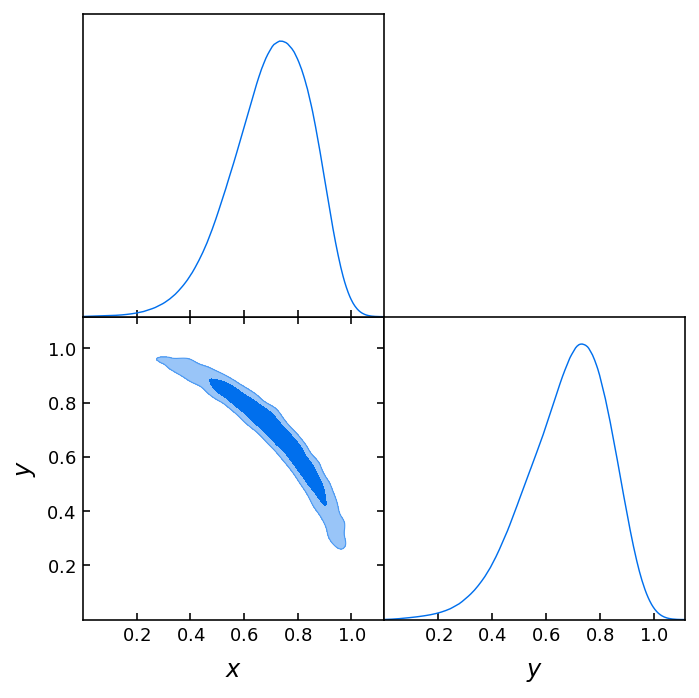

<Figure size 360x270 with 0 Axes>

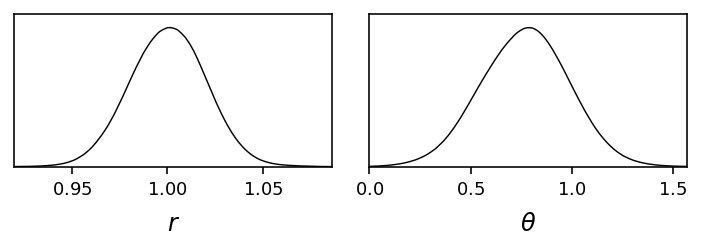

In [10]:
products_alt = sampler_alt.products()
gdsamples_alt = MCSamplesFromCobaya(
    updated_info_alt, products_alt["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_alt, ["x", "y"], filled=True)
gdplot = gdplt.get_single_plotter(width_inch=5)
gdplot.plots_1d(gdsamples_alt, ["r", "theta"], nx=2);

## Even better: sampling directly on $r$ and $\theta$

In [11]:
# r and theta are better variables with which to sample this posterior:
# the gaussian ring is an approximate gaussian on r (and uniform on theta),
# and the x = y band is an approximate gaussian on theta.
# Given how much simpler the posterior is in these variables,
# we should expect a more accurate result with the same number of samples,
# since now we don't have the complication of having to go around the ring.

from copy import deepcopy
info_rtheta = deepcopy(info)
info_rtheta["params"] = {
    "r": {"prior": {"min": 0, "max": 2}, "ref": 1,
          "proposal": 0.01, "drop": True},
    "theta": {"prior": {"min": 0, "max": np.pi/2}, "ref": 0,
               "proposal": 0.5, "latex": r"\theta", "drop": True},
    "x": lambda r,theta: r*np.cos(theta),
    "y": lambda r,theta: r*np.sin(theta)}
# Since our likelihood understands (x, y), not (r, theta), we *define* (x, y) in terms
# of (r, theta), to which we give priors, and *drop* them, i.e. indicate that they should
# not be passed to any likelihood.

# The priors above are just linear with specific ranges. There is also a Jacobian
# from the change of variables, which we can include as an additional prior.
# Here the Jacobian is just proportional to r, so the log-prior is proportional to log(r)
info_rtheta["prior"] = {"Jacobian" : lambda r: np.log(r)}

# We need to reformulate the prior in terms of the new sampled parameters: r, theta
info_rtheta["prior"]["x_eq_y_band"] = lambda r, theta: stats.norm.logpdf(
    r * (np.cos(theta) - np.sin(theta)), loc=0, scale=0.3)
updated_info_rtheta, sampler_rtheta = run(info_rtheta)

[prior] *WARNING* External prior 'Jacobian' loaded. Mind that it might not be normalized!
[prior] *WARNING* External prior 'x_eq_y_band' loaded. Mind that it might not be normalized!
[tools] *WARNING* *DEPRECATION*: The env var 'COBAYA_MODULES' will be deprecated in favor of 'COBAYA_PACKAGES_PATH' in the next version. Please, use that one instead.
[ring] Initialized external likelihood.
[tools] *WARNING* *DEPRECATION*: The env var 'COBAYA_MODULES' will be deprecated in favor of 'COBAYA_PACKAGES_PATH' in the next version. Please, use that one instead.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {ring: 9580.0}
[mcmc] *WARNING* `i_last_slow_block` is only well defined when dragging.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: r:1, theta:0
[mcmc] Sampl

[mcmc]  - Convergence of means: R-1 = 0.009663 after 2640 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2720 samples accepted.
[mcmc]  - Acceptance rate: 0.300
[mcmc]  - Convergence of means: R-1 = 0.010244 after 2720 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2800 samples accepted.
[mcmc]  - Acceptance rate: 0.299
[mcmc]  - Convergence of means: R-1 = 0.006088 after 2800 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2880 samples accepted.
[mcmc]  - Acceptance rate: 0.300
[mcmc]  - Convergence of means: R-1 = 0.004446 after 2880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2960 samples accepted.
[mcmc]  - Acceptance rate: 0.301
[mcmc]  - Convergence of means: R-1 = 0.005982 after 2960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Lea

[mcmc]  - Convergence of means: R-1 = 0.003091 after 5680 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5760 samples accepted.
[mcmc]  - Acceptance rate: 0.296
[mcmc]  - Convergence of means: R-1 = 0.004730 after 5760 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5840 samples accepted.
[mcmc]  - Acceptance rate: 0.296
[mcmc]  - Convergence of means: R-1 = 0.005775 after 5840 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5920 samples accepted.
[mcmc]  - Acceptance rate: 0.296
[mcmc]  - Convergence of means: R-1 = 0.005109 after 5920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6000 samples accepted.
[mcmc]  - Acceptance rate: 0.296
[mcmc]  - Convergence of means: R-1 = 0.002937 after 6000 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Lea

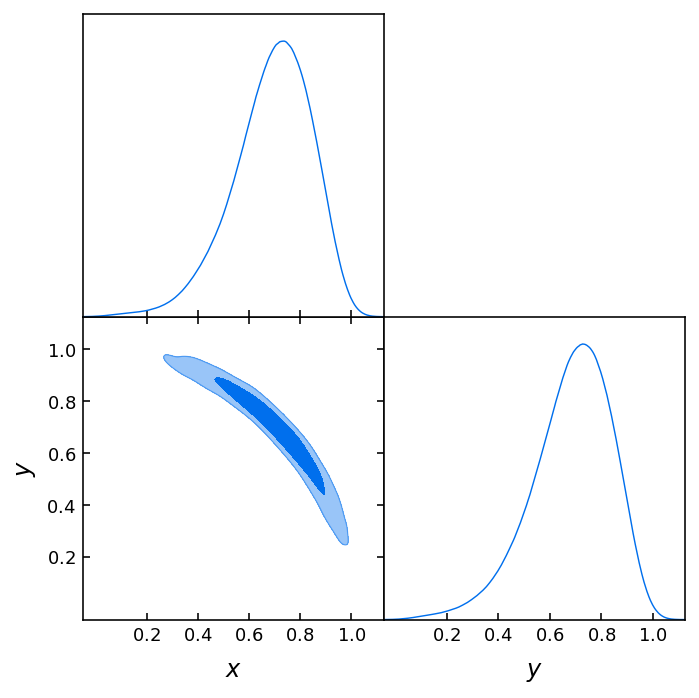

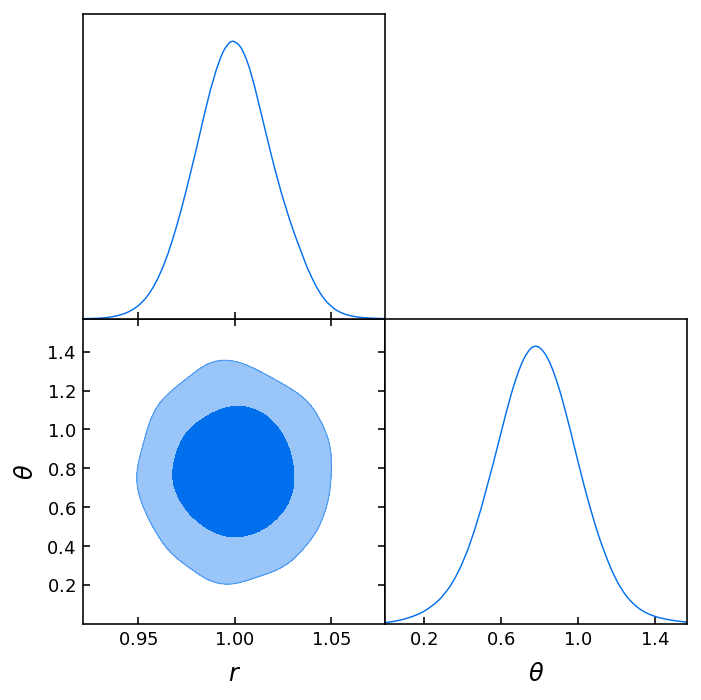

In [12]:
products_rtheta = sampler_rtheta.products()
gdsamples_rtheta = MCSamplesFromCobaya(
    updated_info_rtheta, products_rtheta["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_rtheta, ["x", "y"], filled=True)
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples_rtheta, ["r", "theta"], filled=True)